In [5]:
import pickle
import matplotlib.pyplot as plt
import cv2
import numpy as np

import time
import glob

In [6]:
PATH = '/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/'
ORIGINAL_FILE = PATH+'agg_filez.pkl'
TRAIN_DATA_FILES = PATH+'agg_filez*.pkl'
FINAL_FILE = PATH+'agg_filez_FINAL.pkl'


In [7]:
def displayImage(_image):
    plt.imshow(_image)
    plt.show()
    
def color_shift(_image, _rgb = 'b', _value = 0):
    output = np.zeros_like(_image)
    output[:] = _image[:]
    if(_rgb=='r'):
        output[:,:,0] += _value
    elif(_rgb=='g'):
        output[:,:,1] += _value
    elif(_rgb=='b'):
        output[:,:,2] += _value
    else:
        print('Please choose between r g b')
    return output

def color_shift_ratio(_image, _rgb = 'b', _ratio = 1):
    output = np.zeros_like(_image)
    output[:] = _image[:]
    if(_rgb=='r'):
        output[:,:,0] = output[:,:,0] * _ratio
    elif(_rgb=='g'):
        output[:,:,1] = output[:,:,1] * _ratio
    elif(_rgb=='b'):
        output[:,:,2] = output[:,:,2] * _ratio
    else:
        print('Please choose between r g b')
    return output

def flip_image(_image,_label):
    output_labels = np.zeros_like(_label)
    if(_label[1] == 1):
        output_labels[2] = 1
    elif(_label[2] == 1):
        output_labels[1] = 1
    else:
        output_labels[0] = 1
    
    return cv2.flip(_image,1), output_labels

def brightness_image(_image,_random=False):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(_image, cv2.COLOR_RGB2HSV)
    if(_random):
        ratio = 1.0 + 0.6 * (np.random.rand() - 0.5)
    else:
        ratio = 1.5 
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def random_shadow(image):
    """
    Generates and adds random shadow
    """
    IMAGE_WIDTH = image.shape[1]
    IMAGE_HEIGHT = image.shape[0]
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = (IMAGE_WIDTH * np.random.rand()), 0
    x2, y2 = (IMAGE_WIDTH * np.random.rand()), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]    
    
    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line:
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.9)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def open_train_file(_file):
    with open(_file,'rb') as f:  
        train, label = pickle.load(f, encoding='latin1')

    print('Train size: '+str(len(original_train)))
    return train, label

def save_train_file(_file,_train, _label,_as_nparray=False):
    if(_as_nparray):
        saved_image = np.asarray(_train)
        saved_label = np.asarray(_label)
        np.savez(_file,train=_train,label=_label)
    else:
        with open(_file,'wb') as f:
            pickle.dump([_train, _label], f, protocol=2)
        print(_file + ' saved!')
    
    
def flip_train_data(_file,_train,_label):
    # Flipped
    flipped_train = []
    flipped_label = []
    for idx in range(len(_train)):
        t, l = flip_image(_train[idx],_label[idx])
        flipped_train.append(t)
        flipped_label.append(l)

    flipped_file = PATH+_file+'.pkl'
    save_train_file(flipped_file,flipped_train,flipped_label)
    
def bright_train_data(_file,_train,_label):
    # Brightness
    brightness_train = []
    for idx in range(len(_train)):
        t = brightness_image(_train[idx])
        brightness_train.append(t)

    brightness_file = PATH+_file+'.pkl'
    save_train_file(brightness_file,brightness_train,_label)
    
def shadow_train_data(_file,_train,_label):
    # Shadow
    shadow_train = []
    for idx in range(len(_train)):
        t = random_shadow(_train[idx])
        shadow_train.append(t)

    shadow_file = PATH+_file+'.pkl'
    save_train_file(shadow_file,shadow_train,_label)
    
def color_train_data(_file,_train,_label,_ratio):
    # Color Shift
    color_train = []
    for idx in range(len(_train)):
        t = color_shift_ratio(_train[idx],'b',_ratio)
        color_train.append(t)

    color_file = PATH+_file+'.pkl'
    save_train_file(color_file,color_train,_label)
    
def print_time(_start,_end):
    time = (_end - _start)
    print((">>> Time take: %s \n")%(time))
    
def load_file(_file):
    with open(_file,'rb') as f:  
        t, l = pickle.load(f, encoding='latin1')
    return t, l



def load_agg_train_data(_train_files):
    #load first to see total size
    training_data = glob.glob(_train_files)
    t, l = load_file(training_data[0])

    train_size = len(t)*len(training_data)
    print('Total size: '+str(train_size))

    # Start array
    total_train = np.zeros([train_size,240,320,3])
    total_label = np.zeros([train_size,3])
    i = 0

    for pkl in training_data:
        print(pkl)
        t = []
        l = []
        t, l = load_file(pkl)
        for index in range(len(t)):
            total_train[i] = t[index]
            total_label[i] = l[index]
            i += 1

    return total_train, total_label
    
#     total_train = np.zeros([31056,240,320,3])
#     total_label = np.zeros([31056,3])
#     i = 0
#     # Start array
#     image_array = []
#     label_array = []
#     training_data = glob.glob(_train_files)
#     for pkl in training_data:
#         print(pkl)
#         t = []
#         l = []
#         t, l = load_file(pkl)
#         for index in range(len(t)):
#             total_train[i] = t[index]
#             total_label[i] = l[index]
#             i += 1
# #             image_array = image_array + t
# #             label_array = label_array + l

# #     print(("final size: tain  %s and label %s")%(str(len(image_array)), str(len(label_array))))
# #     return image_array, label_array
#     return total_train, total_label

## Execution

In [11]:
# Load all train data
# original_train = []
# original_label = []
original_train, original_label = open_train_file(ORIGINAL_FILE)

Train size: 1941


In [17]:
# Save as python2 pickle
save_train_file( PATH+'agg_filez_2.pkl',original_train, original_label)

/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_2.pkl saved!


In [12]:
# Save flipped train data
flip_train_data('agg_filez_flipped',original_train,original_label)

/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_flipped.pkl saved!


In [14]:
# Load Flipped Image
flip_train, flip_label = open_train_file(PATH+'agg_filez_flipped.pkl')

Train size: 1941


In [15]:
# Save bright image
bright_train_data('agg_filez_bright',original_train,original_label)
bright_train_data('agg_filez_flipped_bright',flip_train,flip_label)

/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_bright.pkl saved!
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_flipped_bright.pkl saved!


In [28]:
# Load Flipped Image
bright_train, bright_label = open_train_file(PATH+'agg_filez_bright.pkl')
flipped_bright_train, flipped_bright_label = open_train_file(PATH+'agg_filez_flipped_bright.pkl')

Train size: 1941
Train size: 1941


In [16]:
# Save bright image
color_train_data('agg_filez_color',original_train,original_label,1.8)
color_train_data('agg_filez_flipped_color',flip_train,flip_label,1.8)

/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_color.pkl saved!
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_flipped_color.pkl saved!


In [ ]:
color_train_data('agg_filez_color2',original_train,original_label,-0.2)
color_train_data('agg_filez_flipped_color2',flip_train,flip_label,-0.2)

In [40]:
color_train, color_label = open_train_file(PATH+'agg_filez_color.pkl')
flipped_color_train, flipped_color_label = open_train_file(PATH+'agg_filez_flipped_color.pkl')

color2_train, color2_label = open_train_file(PATH+'agg_filez_color2.pkl')
flipped_color2_train, flipped_color2_label = open_train_file(PATH+'agg_filez_flipped_color2.pkl')

Train size: 1941
Train size: 1941
Train size: 1941
Train size: 1941


In [41]:
shadow_train_data('agg_filez_shadow',original_train,original_label)
shadow_train_data('agg_filez_flipped_shadow',flip_train,flip_label)

shadow_train_data('agg_filez_bright_shadow',bright_train,bright_label)
shadow_train_data('agg_filez_flipped_bright_shadow',flipped_bright_train,flipped_bright_label)

shadow_train_data('agg_filez_color_shadow',color_train,color_label)
shadow_train_data('agg_filez_flipped_color_shadow',flipped_color_train,flipped_color_label)

shadow_train_data('agg_filez_color2_shadow',color2_train,color2_label)
shadow_train_data('agg_filez_flipped_color2_shadow',flipped_color2_train,flipped_color2_label)

/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_shadow.pkl saved!
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_flipped_shadow.pkl saved!
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_bright_shadow.pkl saved!
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_flipped_bright_shadow.pkl saved!
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_color_shadow.pkl saved!
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_flipped_color_shadow.pkl saved!
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_color2_shadow.pkl saved!
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_flipped_color2_shadow.pkl

In [5]:
#Load Data
TRAIN_DATA_FILES = PATH+'agg_filez*.pkl'
image_array, label_array = load_agg_train_data(TRAIN_DATA_FILES)

Total size: 11646
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_flipped_color.pkl
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez.pkl
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_bright.pkl
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_color.pkl
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_flipped.pkl
/Users/Rodrigo/Google Drive/Rodrigo/Desenvolvimentos/Self Driving RC Car/Sync_train_data/agg_filez_flipped_bright.pkl


In [6]:
print(image_array.shape)
# training_data = glob.glob(TRAIN_DATA_FILES)


(11646, 240, 320, 3)


In [ ]:
# print(training_data)

In [ ]:
# Save as Pickle
save_train_file(FINAL_FILE,image_array,label_array)

In [1]:
import pandas as pd

In [11]:
file = PATH+'agg_filez_color2.pkl'
train_test, label_test = load_file(file)
len(train_test)

1941

In [3]:
total_train = np.zeros([31056,240,320,3])
total_label = np.zeros([31056,3])

In [12]:
for index in range(total_train.shape[0]):
    total_train[index] = image_array[index]
    total_label[index] = label_array[index]

In [ ]:
FINAL_FILE_NPz = PATH+'agg_filez_FINAL.npz'
save_train_file(FINAL_FILE_NPz,total_train,total_label)

## Tests

In [ ]:
test_image = t[0]
test_image_label = l[0]
test_image2 = t[500]
test_image2_label = l[500]

displayImage(test_image)
print(test_image_label)
displayImage(test_image2)
print(test_image2_label)

In [ ]:
new_image, new_label = flip_image(test_image,test_image_label)
displayImage(new_image)
print(new_label)

original


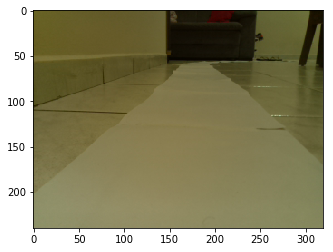

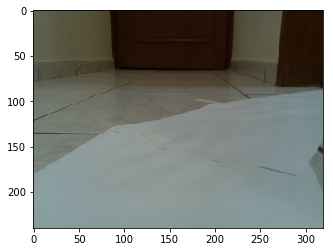

blue+200


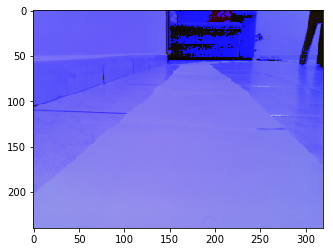

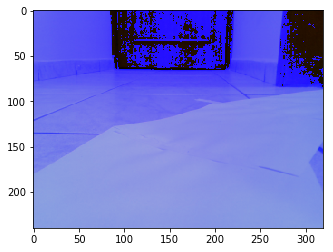

In [36]:

test_image = original_train[0]
test_image2 = original_train[100]
print('original')
displayImage(test_image)
displayImage(test_image2)

# print('red+100')
# displayImage(color_shift(test_image2,'r',50))
# print('red+200')
# displayImage(color_shift(test_image2,'r',250))

# print('green+100')
# displayImage(color_shift(test_image2,'g',50))
# print('green+200')
# displayImage(color_shift(test_image2,'g',250))

# print('blue+100')
# displayImage(color_shift(test_image2,'b',50))
print('blue+200')
# displayImage(color_shift(test_image2,'b',120))

ratio = -0.2
displayImage(color_shift_ratio(test_image,'b',ratio))
# displayImage(color_shift_ratio(test_image,'g',ratio))
# displayImage(color_shift_ratio(test_image,'r',ratio))

displayImage(color_shift_ratio(test_image2,'b',ratio))
# displayImage(color_shift_ratio(test_image2,'g',ratio))
# displayImage(color_shift_ratio(test_image2,'r',ratio))


# print('blue+green')

# displayImage(color_shift(color_shift(test_image,'b',80),'r',80))
# displayImage(color_shift(color_shift(test_image,'b',120),'r',120))


In [ ]:
displayImage(test_image2)
displayImage(random_brightness(test_image2))

In [ ]:
displayImage(test_image2)
displayImage(random_shadow(test_image2))

In [ ]:
new_array = 
test_image2_label[0]

In [ ]:
output = np.zeros_like(test_image2_label)

In [ ]:
output